In [1]:
# Imports
import os
import shutil
import nibabel as nib
import numpy as np
import random
import matplotlib.pyplot as plt
from random import shuffle
from glob import glob
from scipy import ndimage
from nilearn.image import resample_to_img, resample_img
from nilearn.masking import compute_background_mask, compute_epi_mask
from nilearn.plotting import plot_roi, plot_epi, plot_img, plot_anat

In [2]:
# Set working directory
os.chdir('/home/uziel/DISS')
test_flag = 0

In [3]:
#List all sequences per subject
if test_flag:
    root = './data/ISLES2017/testing'
else:
    root = './data/ISLES2017/training'

subjects_paths = sorted(os.listdir(root))
channels_per_subject = dict() # groups relevant sequences per subject
for i in range(len(subjects_paths)):
    s_path = os.path.join(root, subjects_paths[i])
    channels_per_subject[i] = [y
                               for x in os.walk(s_path)
                               for y in
                               glob(os.path.join(x[0], '*ADC*.nii')) or
                               glob(os.path.join(x[0], '*MTT*.nii')) or
                               glob(os.path.join(x[0], '*rCBF*.nii')) or
                               glob(os.path.join(x[0], '*rCBV*.nii')) or
                               glob(os.path.join(x[0], '*Tmax*.nii')) or
                               glob(os.path.join(x[0], '*TTP*.nii')) or
                               glob(os.path.join(x[0], '*OT*.nii'))
                              ]


In [ ]:
# Resample images to same voxel size
if test_flag:
    root = './data_processed/ISLES2017/testing'
else:
    root = './data_processed/ISLES2017/training'

# define template path
template_path = './data/MNI152_T1_1mm_brain.nii.gz'
# define downsample factor
dF = 0.7

# remove and create dir for processed data
if os.path.exists(root): shutil.rmtree(root)
os.makedirs(root)

# load template image
template = nib.load(template_path)

for subject in channels_per_subject.keys():
    # create subdirectory per subject
    subject_root = os.path.join(root, str(subject))
    os.mkdir(subject_root)
    
    subject_imgs = []
    # Resample img to match template (1mm voxel size / dF)
    for channel_file in channels_per_subject[subject]:
        if 'OT' in channel_file:            
            # label must be resampled using nearest neighbour
            resampled_img = resample_img(channel_file,
                                         template.affine[:3,:3]/dF,
                                         interpolation='nearest')
        else:
            resampled_img = resample_img(channel_file,
                                         template.affine[:3,:3]/dF,
                                         interpolation='continuous')

        subject_imgs.append([resampled_img, channel_file])
        
    # compute subject brain mask given all original channels (ignore label channel)
    mask = compute_background_mask([y for x,y in subject_imgs if not 'OT' in y])
    # dilate mask to adjust better to boundaries
    dilated_mask_data = ndimage.binary_dilation(mask.dataobj, iterations=2)
    mask = nib.nifti1.Nifti1Image(mask.dataobj.astype(np.int32), mask.affine)
    # resample mask to match template
    mask = resample_img(mask,
                        template.affine[:3,:3]/dF,
                        interpolation='nearest')
    # dilate mask to adjust better to boundaries
    dilated_mask_data = ndimage.binary_dilation(mask.dataobj)
    mask = nib.nifti1.Nifti1Image(mask.dataobj.astype(np.int32), mask.affine)
    # save mask
    nib.save(mask, os.path.join(subject_root, 'mask.nii.gz'))
   
    # standarize each image within mask and save
    # to zero-mean and unit variance
    for img, channel_file in subject_imgs:
        # don't try to normalize label channel
        if 'OT' not in channel_file:
            # get data within mask
            temp_data = img.dataobj * mask.dataobj
            # compute mean and variance of non-zero values
            mean = np.mean(temp_data[np.nonzero(temp_data)])
            std = np.std(temp_data[np.nonzero(temp_data)])
            # substract mean and divide by std all non-zero values
            temp_data[np.nonzero(temp_data)] = (temp_data[np.nonzero(temp_data)] - mean) / std
            # build standarize image with standarize data and unmodified affine
            img = nib.nifti1.Nifti1Image(temp_data.astype(np.float32), img.affine)
        else:
            img = nib.nifti1.Nifti1Image(img.get_data().astype(np.int32), img.affine)

        # save image
        file_name = os.path.basename(channel_file)
        nib.save(img, os.path.join(subject_root, file_name) + '.gz')
      
    print("Subject " + str(subject) + " finished.")


In [ ]:
def data_to_file(data, path):
    out = open(path, "w")
    for line in data:
        print >> out, line
    out.close()

In [ ]:
# Generate files listing all images per channel
if test_flag:
    root = './data_processed/ISLES2017/testing'
else:
    root = './data_processed/ISLES2017/training'
    
channels = {}
# channels - sequences os.path.join('../../../../../../', x) needed for deepmedic
channels['Channels_ADC'] = sorted([os.path.join('../../../../../../', y)
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*ADC*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_MTT'] = sorted([os.path.join('../../../../../../', y)
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*MTT*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_rCBF'] = sorted([os.path.join('../../../../../../', y)
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBF*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_rCBV'] = sorted([os.path.join('../../../../../../', y)
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBV*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_Tmax'] = sorted([os.path.join('../../../../../../', y)
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*Tmax*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_TTP'] = sorted([os.path.join('../../../../../../', y)
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*TTP*.nii.gz'))
                                   if 'clone' not in y
                                  ])
# labels
channels['GtLabels'] = sorted([os.path.join('../../../../../../', y)
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], '*OT*.nii.gz'))
                               if 'clone' not in y
                              ])
# masks
channels['RoiMasks'] = sorted([os.path.join('../../../../../../', y)
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], 'mask.nii.gz'))
                               if 'clone' not in y
                              ])


In [ ]:
####################################################################
##### FILES FOR DM_V0 (BASELINE) AND TRANSFER LEARNING VARIANT #####
####################################################################
# set base config path
root_base = './ischleseg/deepmedic/versions/DM_V0_base'
root_base_transfer = './ischleseg/deepmedic/versions/DM_V0_transfer_base'

# k-fold cross-validation in training data, ignore test data for now
# k = 5
k = 5

# random subject indices
indices = range(len(channels['Channels_ADC']))
random.shuffle(indices)
# Divide subject indices in 5 equally sized chunks
chunk_size = int(np.ceil(len(indices)/float(k)))
subjects_all = [indices[i:i + chunk_size]
                for i in xrange(0, len(indices), chunk_size)]

# for each iteration, choose:
# ... 3 chunks for training
# ... 1 chunk for validation
# ... 1 chunk for test
for i in range(k):
    subjects_training = subjects_all[i % k] + subjects_all[(i+1) % k] + subjects_all[(i+2) % k]
    subjects_validation = subjects_all[(i+3) % k]
    subjects_test = subjects_all[(i+4) % k]
    
    # set model variant dir
    s_path = os.path.join(os.path.dirname(root_base), 'DM_V0_' + str(i))
    s_path_transfer = os.path.join(os.path.dirname(root_base_transfer), 'DM_V0_transfer_' + str(i))
    # make model variant dir
    if not os.path.exists(s_path): shutil.copytree(root_base, s_path)
    if not os.path.exists(s_path_transfer): shutil.copytree(root_base_transfer, s_path_transfer)

    # set model variant config dirs
    test_path = os.path.join(s_path, 'configFiles/test')
    test_path_transfer = os.path.join(s_path_transfer, 'configFiles/test')
    train_path = os.path.join(s_path, 'configFiles/train')
    train_path_transfer = os.path.join(s_path_transfer, 'configFiles/train')
    validation_path = os.path.join(s_path, 'configFiles/validation')
    validation_path_transfer = os.path.join(s_path_transfer, 'configFiles/validation')

    # make model variant config dirs
    if not os.path.exists(test_path): os.makedirs(test_path)
    if not os.path.exists(test_path_transfer): os.makedirs(test_path_transfer)
    if not os.path.exists(train_path): os.makedirs(train_path)
    if not os.path.exists(train_path_transfer): os.makedirs(train_path_transfer)
    if not os.path.exists(validation_path): os.makedirs(validation_path)
    if not os.path.exists(validation_path_transfer): os.makedirs(validation_path_transfer)
    
    for name, files in channels.iteritems():
        # save train channel files
        data_to_file([files[j] for j in subjects_training], os.path.join(train_path, 'train' + name + '.cfg'))
        data_to_file([files[j] for j in subjects_training], os.path.join(train_path_transfer, 'train' + name + '.cfg'))
        # save validation channel files
        data_to_file([files[j] for j in subjects_validation], os.path.join(validation_path, 'validation' + name + '.cfg'))
        data_to_file([files[j] for j in subjects_validation], os.path.join(validation_path_transfer, 'validation' + name + '.cfg'))
        # save test channel files
        data_to_file([files[j] for j in subjects_test], os.path.join(test_path, 'test' + name + '.cfg'))
        data_to_file([files[j] for j in subjects_test], os.path.join(test_path_transfer, 'test' + name + '.cfg'))

        # save names of predictions
        names = ['SMIR.ischleseg_' + 'DM_V0_' + str(i) + '.' + os.path.basename(x).split('.')[-3]
                 for x in [channels['Channels_MTT'][j] for j in subjects_test]]
        data_to_file(names, os.path.join(test_path, 'testNamesOfPredictions.cfg'))
        data_to_file(names, os.path.join(test_path_transfer, 'testNamesOfPredictions.cfg'))

        # save names of predictions
        names = ['SMIR.ischleseg_' + 'DM_V0_' + str(i) + '.' + os.path.basename(x).split('.')[-3]
                 for x in [channels['Channels_MTT'][j] for j in subjects_validation]]
        data_to_file(names, os.path.join(validation_path, 'validationNamesOfPredictions.cfg'))
        data_to_file(names, os.path.join(validation_path_transfer, 'validationNamesOfPredictions.cfg'))

# modelConfig,cfg, trainConfig.cfg and testConfig.cfg must be added and modified manually.


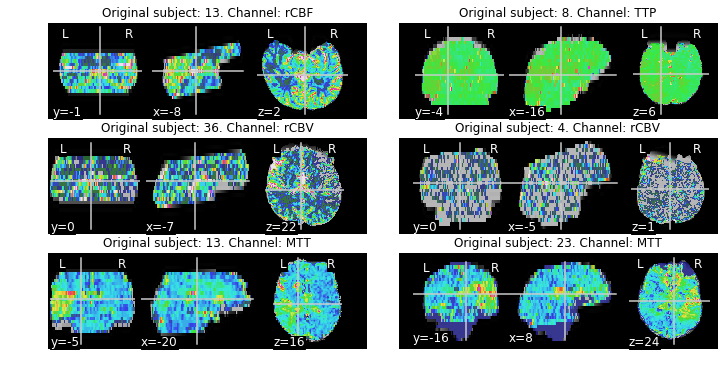

In [14]:
####################################
##### TEST PREPROCESSING FILES #####
####################################

# Generate files listing all images per channel
if test_flag:
    root = './data/ISLES2017/testing'
else:
    root = './data/ISLES2017/training'
    
channels = {}
channels['Channels_ADC'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*ADC*.nii'))
                                  ])
channels['Channels_MTT'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*MTT*.nii'))
                                  ])
channels['Channels_rCBF'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBF*.nii'))
                                  ])
channels['Channels_rCBV'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBV*.nii'))
                                  ])
channels['Channels_Tmax'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*Tmax*.nii'))
                                  ])
channels['Channels_TTP'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*TTP*.nii'))
                                  ])
# labels
channels['GtLabels'] = sorted([y
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], '*OT*.nii'))
                              ])

plt.close('all')
fig = plt.figure(figsize=(12, 6))
indices = range(len(channels['Channels_ADC']))
ax = fig.add_subplot(3, 2, 1)
# take 3 random subjects and check their images
for i in range(6):
    subject = random.choice(indices)
    channel = random.choice([x for x in channels.keys()
                             if 'Labels' not in x])
    ax = fig.add_subplot(3, 2, i+1)
    mask = compute_background_mask([channels[x][subject] for x in channels.keys()])
    plot_roi(channels[channel][subject], mask, figure=fig, axes=ax)
    ax.set_title('Original subject: ' + str(drawn_subjects[i]) + '. Channel: ' + channel.split('_')[-1])
plt.subplots_adjust(wspace=0.1)
plt.savefig('data_original_example.pdf', bbox_inches='tight')

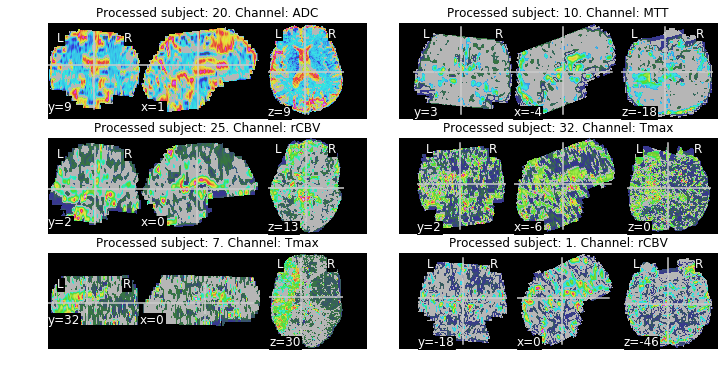

In [16]:
####################################
##### TEST PREPROCESSING FILES #####
####################################

# Generate files listing all images per channel
if test_flag:
    root = './data_processed/ISLES2017/testing'
else:
    root = './data_processed/ISLES2017/training'
    
channels = {}
channels['Channels_ADC'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*ADC*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_MTT'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*MTT*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_rCBF'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBF*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_rCBV'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBV*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_Tmax'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*Tmax*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_TTP'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*TTP*.nii.gz'))
                                   if 'clone' not in y
                                  ])
# labels
channels['GtLabels'] = sorted([y
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], '*OT*.nii.gz'))
                               if 'clone' not in y
                              ])
# masks
channels['RoiMasks'] = sorted([y
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], 'mask.nii.gz'))
                               if 'clone' not in y
                              ])


plt.close('all')
fig = plt.figure(figsize=(12, 6))
indices = range(len(channels['Channels_ADC']))
ax = fig.add_subplot(3, 2, 1)
# take 3 random subjects and check their images
for i in range(6):
    subject = random.choice(indices)
    channel = random.choice([x for x in channels.keys()
                             if 'Labels' not in x
                            and 'Mask' not in x])
    mask = [x for x in channels.keys() if 'Mask' in x][0]
    ax = fig.add_subplot(3, 2, i+1)
    plot_roi(channels[channel][subject], channels[mask][subject], figure=fig, axes=ax)
    ax.set_title('Processed subject: ' + str(subject) + '. Channel: ' + channel.split('_')[-1])
plt.subplots_adjust(wspace=0.1)
plt.savefig('data_processed_example.pdf', bbox_inches='tight')